In [1]:
!python -V

Python 3.10.8


In [2]:
import pickle

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_parquet('./data/green_tripdata_2022-01.parquet')

df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2022-01-01 00:14:21,2022-01-01 00:15:33,N,1.0,42,42,1.0,0.44,3.5,0.50,0.5,0.00,0.0,None,0.3,4.80,2.0,1.0,0.00
1,1,2022-01-01 00:20:55,2022-01-01 00:29:38,N,1.0,116,41,1.0,2.10,9.5,0.50,0.5,0.00,0.0,None,0.3,10.80,2.0,1.0,0.00
2,1,2022-01-01 00:57:02,2022-01-01 01:13:14,N,1.0,41,140,1.0,3.70,14.5,3.25,0.5,4.60,0.0,None,0.3,23.15,1.0,1.0,2.75
3,2,2022-01-01 00:07:42,2022-01-01 00:15:57,N,1.0,181,181,1.0,1.69,8.0,0.50,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2022-01-01 00:07:50,2022-01-01 00:28:52,N,1.0,33,170,1.0,6.26,22.0,0.50,0.5,5.21,0.0,None,0.3,31.26,1.0,1.0,2.75


In [4]:
# Convert the date-associated columns from string to datetime
df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)

In [5]:
# Filter the data to only include trip_type == 2 (which is 'Dispatch')
# Source: https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf
df = df[df.trip_type == 2]

In [6]:
# Create a column called 'duration' to calculate the difference between pickup and dropoff times
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
17,2,2022-01-01 00:12:00,2022-01-01 00:26:26,N,5.0,213,174,1.0,5.57,20.0,...,0.0,0.00,0.0,None,0.3,20.30,2.0,2.0,0.00,0 days 00:14:26
19,2,2022-01-01 00:54:40,2022-01-01 01:17:02,N,5.0,185,119,1.0,6.60,25.0,...,0.0,0.00,0.0,None,0.3,25.30,2.0,2.0,0.00,0 days 00:22:22
24,2,2022-01-01 00:02:43,2022-01-01 00:18:31,N,5.0,66,234,4.0,3.96,25.0,...,0.0,5.61,0.0,None,0.3,33.66,1.0,2.0,2.75,0 days 00:15:48
25,2,2022-01-01 00:45:23,2022-01-01 00:59:38,N,5.0,33,233,4.0,6.20,60.0,...,0.0,12.61,0.0,None,0.3,75.66,1.0,2.0,2.75,0 days 00:14:15
29,2,2022-01-01 00:02:14,2022-01-01 00:02:16,N,5.0,42,264,1.0,0.00,10.0,...,0.0,0.00,0.0,None,0.3,10.30,1.0,2.0,0.00,0 days 00:00:02


In [7]:
# The current format of 'duration' isn't helpful so we need to convert it to total minutes
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
17,2,2022-01-01 00:12:00,2022-01-01 00:26:26,N,5.0,213,174,1.0,5.57,20.0,...,0.0,0.00,0.0,None,0.3,20.30,2.0,2.0,0.00,14.433333
19,2,2022-01-01 00:54:40,2022-01-01 01:17:02,N,5.0,185,119,1.0,6.60,25.0,...,0.0,0.00,0.0,None,0.3,25.30,2.0,2.0,0.00,22.366667
24,2,2022-01-01 00:02:43,2022-01-01 00:18:31,N,5.0,66,234,4.0,3.96,25.0,...,0.0,5.61,0.0,None,0.3,33.66,1.0,2.0,2.75,15.800000
25,2,2022-01-01 00:45:23,2022-01-01 00:59:38,N,5.0,33,233,4.0,6.20,60.0,...,0.0,12.61,0.0,None,0.3,75.66,1.0,2.0,2.75,14.250000
29,2,2022-01-01 00:02:14,2022-01-01 00:02:16,N,5.0,42,264,1.0,0.00,10.0,...,0.0,0.00,0.0,None,0.3,10.30,1.0,2.0,0.00,0.033333


In [8]:
df.duration.describe()

count    2300.000000
mean       17.566174
std        93.381183
min         0.000000
25%         0.100000
50%         4.916667
75%        13.854167
max      1437.666667
Name: duration, dtype: float64

In [9]:
# The above shows that there are some very very long trips and also some very very short trips, which could be considered as faults (outliers)
df.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    2300.000000
mean       17.566174
std        93.381183
min         0.000000
50%         4.916667
95%        35.885833
98%        63.634333
99%       224.295000
max      1437.666667
Name: duration, dtype: float64

In [10]:
# This shows that most of the trips are within one hour, which makes more sense from a business point of view
((df.duration >= 1) & (df.duration <= 60)).mean()

0.5695652173913044

In [11]:
df = df[(df.duration >= 1) & (df.duration <= 60)]
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
17,2,2022-01-01 00:12:00,2022-01-01 00:26:26,N,5.0,213,174,1.0,5.57,20.0,...,0.0,0.00,0.0,None,0.3,20.30,2.0,2.0,0.00,14.433333
19,2,2022-01-01 00:54:40,2022-01-01 01:17:02,N,5.0,185,119,1.0,6.60,25.0,...,0.0,0.00,0.0,None,0.3,25.30,2.0,2.0,0.00,22.366667
24,2,2022-01-01 00:02:43,2022-01-01 00:18:31,N,5.0,66,234,4.0,3.96,25.0,...,0.0,5.61,0.0,None,0.3,33.66,1.0,2.0,2.75,15.800000
25,2,2022-01-01 00:45:23,2022-01-01 00:59:38,N,5.0,33,233,4.0,6.20,60.0,...,0.0,12.61,0.0,None,0.3,75.66,1.0,2.0,2.75,14.250000
31,2,2022-01-01 00:45:22,2022-01-01 00:48:27,N,5.0,240,259,1.0,0.88,10.0,...,0.0,2.08,0.0,None,0.3,12.38,1.0,2.0,0.00,3.083333


In [12]:
# Next we need to figure out what kind of categorical and numerical variables we will use for the model
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']
# We need to convert the numerical values within the category variables to strings
df[categorical] = df[categorical].astype(str)
# Now we need to convert the variables into dicts to import into Dictionary Vectorizor for training purposes
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [13]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
dv.feature_names_

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=107',
 'DOLocationID=11',
 'DOLocationID=112',
 'DOLocationID=114',
 'DOLocationID=116',
 'DOLocationID=117',
 'DOLocationID=119',
 'DOLocationID=121',
 'DOLocationID=122',
 'DOLocationID=123',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=129',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=133',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=137',
 'DOLocationID=138',
 'DOLocationID=139',
 'DOLocationID=14',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=142',
 'DOLocationID=143',
 'DOLocationID=144',
 'DOLocationID=145',
 'DOLocationID=146',
 'DOLocationID=147',
 'DOLocationID=151',
 'DOLocationID=152',
 'DOLocationID=155',
 'DOLocationID=157',
 'DOLocationID=159',
 'DOLocationID=16',
 'DOLocationID=160',
 'DOLocationID=161',
 'DOLocationID=162',
 'DOLocationID=163',
 'DOLocationID=164',
 'DOLocationID=165',
 'DOLocationID=166'

In [14]:
y_train = df['duration'].values

In [15]:
# Now that we have our x and y data sets, we can start training a model
lr = LinearRegression()
# Create the model
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

/tmp/ipykernel_4274/1451195273.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_4274/1451195273.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


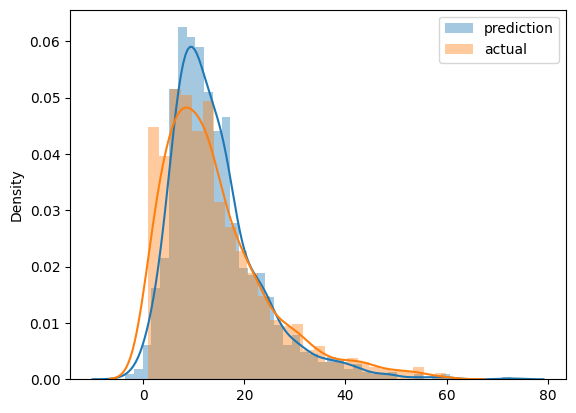

In [16]:
# Let's plot prediction values against actual values to see how good the model is
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')
plt.legend()

In [17]:
# Let's try to estimate the score i.e. performance of this model
mean_squared_error(y_train, y_pred, squared=False)

5.646926920883275

In [18]:
# Let's put the logic into a function so that we don't need to do a lot of copy-pasting
def read_dataframe(filename):
    """Perform pre-processing on a dataframe."""
    df = pd.read_parquet(f'./data/{filename}')
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)

    df = df[df.trip_type == 2]

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df

In [41]:
# This means that the model is wrong on average by almost 6 minutes
# Let's try a different model: Lasso
df_train = read_dataframe('green_tripdata_2022-01.parquet')
df_val = read_dataframe('green_tripdata_2022-02.parquet')

In [42]:
len(df_train), len(df_val)

(1310, 1438)

In [43]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [44]:
# Let's do the same thing for the validation data
categorical = ['PU_DO'] # ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

# Set up training data again
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

# Set up validation data
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [45]:
y_train = df_train['duration'].values
y_val = df_val['duration'].values

In [46]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

8.10808873353748

In [ ]:
with open('./models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [38]:
# Let's try Lasso
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.783033934402808

In [39]:
# Lastly, let's try Ridge
lr = Ridge()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.68958099596436